In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import import_ipynb
import DataLoader_P_speed
import utils
import time
import numpy as np

importing Jupyter notebook from DataLoader_P_speed.ipynb
importing Jupyter notebook from utils.ipynb


In [2]:
class args():
    def __init__(self):
        self.base_out_features = 2048
        self.t_obs = 8
        self.batch_size = 20
        self.scene_shape = [3, 144, 256]
        self.base_shape = [2048, 9, 16]
        self.hidden_size = 128
        self.embedding_size = 64
        self.input_size = 2
        self.output_size = 2
        self.sample = True
        self.n_train_sequences = 12000
        self.n_val_sequences = 3000
        self.trainOrVal = 'train'
        args.citywalks = False
        
        #dataset
        self.jaad_dataset = '../../../../data/smailait-data/jaad/annotations'
        self.dtype = 'train'
        self.from_file = True
        self.file = '/data/smailait-data/train_speed.csv'
        self.val_file = '/data/smailait-data/val_speed.csv'
        self.seq_len = 4
        self.predicted_seq_len = 4
        self.crop = 0.3
        self.activity_h = 9
        self.activity_w = 16
        self.truncate = 0
        self.final_frame_offset = 0
        self.loader_workers = 20
        self.loader_shuffle = True
        self.pin_memory = False
        self.image_resize = [144, 256]
        self.image_size = [1080, 1920]
        self.device='cuda'
        
args = args()

In [3]:
class P_LSTM(nn.Module):
    def __init__(self):
        super(P_LSTM, self).__init__()
        
        self.encoder = nn.LSTM(input_size=4, hidden_size=256)
        
        self.decoder = nn.LSTMCell(input_size=4, hidden_size=256)
        
        self.out = nn.Linear(in_features=256, out_features=4)
        
        self.activation = nn.ReLU()
        
    def forward(self, input_):
        _, (h, c) = self.encoder(input_.permute(1,0,2))
        outputs = torch.tensor([], device='cuda')
        in_dec = input_[:,-1,:]
        h = h.squeeze(0)
        c = c.squeeze(0)
        for i in range(8):
            h, c = self.decoder(in_dec, (h, c))
            output = self.activation(self.out(h))
            outputs = torch.cat((outputs, output.unsqueeze(1)), dim = 1)
            in_dec = output.detach()
        return outputs

In [4]:
net = P_LSTM().to('cuda')

In [5]:
train, val, test = DataLoader_P_speed.data_loader(args)

frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
val  loaded


In [6]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold = 1e-4, verbose=True)
criterion = nn.MSELoss()
train_scores = []
val_scores = []

In [7]:
for epoch in range(100):
    avg_epoch_train_loss = 0
    avg_epoch_val_loss = 0
    ade = 0
    fde = 0
    aiou = 0
    fiou = 0
    counter = 0
    for idx, (_, _, obs, target) in enumerate(train):
        counter += 1
        obs = obs.type(torch.float32).to(device='cuda')
        target = target.type(torch.float32).to(device='cuda')
        
        net.zero_grad()
        preds = net(obs)
        train_loss = criterion(preds, target[:,:-1,:])/10000
        train_loss.backward()
        optimizer.step()
        
        avg_epoch_train_loss += float(train_loss)
        
    avg_epoch_train_loss/=counter
    train_scores.append(avg_epoch_train_loss)
    
    counter=0
    for idx, (_, _, obs, target) in enumerate(val):
        counter+=1
        obs = obs.type(torch.float32).to(device='cuda')
        target = target.type(torch.float32).to(device='cuda')
        
        with torch.no_grad():
            preds = net(obs)
            val_loss = criterion(preds, target[:,:-1,:])/10000
            ade += float(utils.ADE_c(preds, target[:,:-1,:]))
            fde += float(utils.FDE_c(preds, target[:,:-1,:]))
            aiou += float(utils.AIOU(preds, target[:,:-1,:].to('cuda')))
            fiou += float(utils.FIOU(preds, target[:,:-1,:].to('cuda')))
            
        avg_epoch_val_loss += float(val_loss)
        
    avg_epoch_val_loss/=counter
    val_scores.append(avg_epoch_val_loss)
    ade/=counter
    fde/=counter
    aiou/=counter
    fiou/=counter
    
    scheduler.step(val_loss)
    
    
    print('e:', epoch, ' | t_loss: %.4f'% avg_epoch_train_loss, ' | v_loss: %.4f'% avg_epoch_val_loss, 
          '| ade: %.4f'% ade, '| fde: %.4f'% fde, '| aiou: %.4f'% aiou, '| fiou: %.4f'% fiou)


e: 0  | t_loss: 33.6954  | v_loss: 26.6677 | ade: 962.9426 | fde: 965.7443 | aiou: 0.0000 | fiou: 0.0000
e: 1  | t_loss: 24.1978  | v_loss: 19.0371 | ade: 791.4273 | fde: 793.6944 | aiou: 0.0000 | fiou: 0.0000
e: 2  | t_loss: 17.5575  | v_loss: 13.7163 | ade: 649.9295 | fde: 652.3553 | aiou: 0.0000 | fiou: 0.0000
e: 3  | t_loss: 12.9515  | v_loss: 10.1308 | ade: 541.3392 | fde: 544.9409 | aiou: 0.0005 | fiou: 0.0006
e: 4  | t_loss: 9.7966  | v_loss: 7.7244 | ade: 461.8297 | fde: 467.0661 | aiou: 0.0022 | fiou: 0.0022
e: 5  | t_loss: 7.6092  | v_loss: 6.0680 | ade: 401.9812 | fde: 409.1362 | aiou: 0.0056 | fiou: 0.0055
e: 6  | t_loss: 6.0414  | v_loss: 4.8720 | ade: 355.0601 | fde: 365.0540 | aiou: 0.0097 | fiou: 0.0096
e: 7  | t_loss: 4.8765  | v_loss: 3.9749 | ade: 315.9939 | fde: 326.7173 | aiou: 0.0141 | fiou: 0.0126
e: 8  | t_loss: 3.9042  | v_loss: 3.2018 | ade: 279.6132 | fde: 288.0046 | aiou: 0.0156 | fiou: 0.0164
e: 9  | t_loss: 3.1367  | v_loss: 2.6255 | ade: 248.3458 | fde: 2

e: 79  | t_loss: 0.0537  | v_loss: 0.0636 | ade: 30.7564 | fde: 45.0746 | aiou: 0.3453 | fiou: 0.2606
e: 80  | t_loss: 0.0536  | v_loss: 0.0636 | ade: 30.6863 | fde: 45.0980 | aiou: 0.3459 | fiou: 0.2600
e: 81  | t_loss: 0.0535  | v_loss: 0.0635 | ade: 30.7579 | fde: 45.0156 | aiou: 0.3453 | fiou: 0.2604
e: 82  | t_loss: 0.0534  | v_loss: 0.0633 | ade: 30.6708 | fde: 45.0120 | aiou: 0.3463 | fiou: 0.2601
e: 83  | t_loss: 0.0533  | v_loss: 0.0633 | ade: 30.6566 | fde: 45.2224 | aiou: 0.3466 | fiou: 0.2579
Epoch    84: reducing learning rate of group 0 to 1.0000e-06.
e: 84  | t_loss: 0.0532  | v_loss: 0.0633 | ade: 30.6932 | fde: 45.1546 | aiou: 0.3452 | fiou: 0.2567
e: 85  | t_loss: 0.0529  | v_loss: 0.0632 | ade: 30.6591 | fde: 45.1405 | aiou: 0.3453 | fiou: 0.2575
e: 86  | t_loss: 0.0529  | v_loss: 0.0632 | ade: 30.6618 | fde: 45.1340 | aiou: 0.3454 | fiou: 0.2578
e: 87  | t_loss: 0.0529  | v_loss: 0.0632 | ade: 30.6392 | fde: 45.1403 | aiou: 0.3459 | fiou: 0.2581
e: 88  | t_loss: 0.0

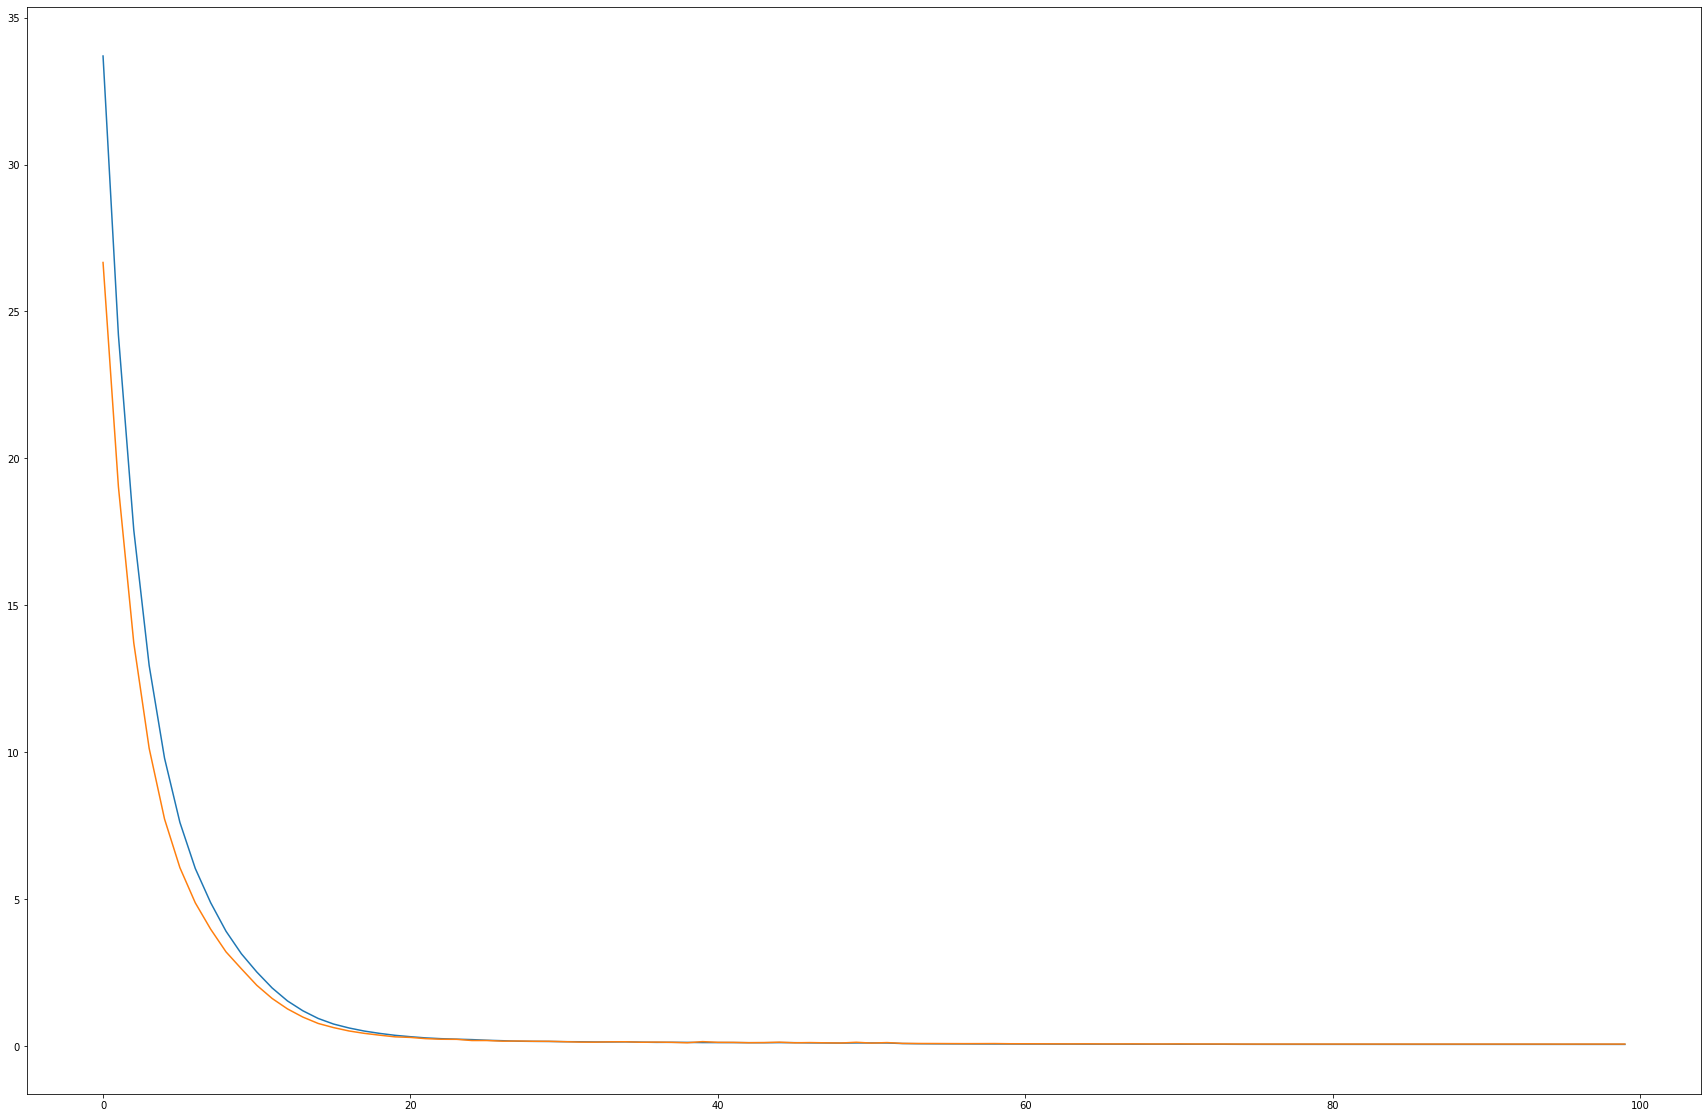

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.plot(list(range(len(train_scores))), train_scores)
plt.plot(list(range(len(val_scores))), val_scores)
plt.show()

In [9]:
#torch.save(net.state_dict(), '/data/smailait-data/baseline_models/seq2seq/seq2seq_pos_250epochs.pkl')

In [11]:
avg_epoch_val_loss = 0
ade = 0
fde = 0
aiou = 0
fiou = 0
counter=0
for idx, (_, _, obs, target) in enumerate(test):
    counter+=1
    obs = obs.type(torch.float32).to(device='cuda')
    target = target.type(torch.float32).to(device='cuda')

    with torch.no_grad():
        preds = net(obs)
        val_loss = criterion(preds, target[:,:-1,:])
        ade += float(utils.ADE_c(preds, target[:,:-1,:].to('cuda')))
        fde += float(utils.FDE_c(preds, target[:,:-1,:].to('cuda')))
        aiou += float(utils.AIOU(preds, target[:,:-1,:].to('cuda')))
        fiou += float(utils.FIOU(preds, target[:,:-1,:].to('cuda')))

    avg_epoch_val_loss += float(val_loss)

avg_epoch_val_loss/=counter
ade/=counter
fde/=counter     
aiou/=counter
fiou/=counter
print('val_loss: %.4f'% avg_epoch_val_loss, '| ade: %.4f'% ade, '| fde: %.4f'% fde, 
      '| aiou: %.4f'% aiou, '| fiou: %.4f'% fiou)

val_loss: 614.1133 | ade: 31.5134 | fde: 46.4679 | aiou: 0.3903 | fiou: 0.2985
